# Dataset Insights
This study looks at the spatio-temporal patterns in the _bus arrival time_ dataset to identify `where`, `when` & tentative reasons `why` scheduled deviations happen.

----
## Download & Preparation
> ℹ️ **NOTE:** This technical section is for report interactivity & reproducibility purpose only & can be skipped for regular readers. Please be PATIENT as certain cells can take a few minutes to complete.

In [1]:
%%capture

# Custom code
from source.data_loaders import *
from source.visualizations import *

# Notebook configurations
from IPython.display import display, Markdown
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  # multi cell output

""" TIME EXPENSIVE - DO THIS JUST ONCE
# Locally download auxiliary data.
download_manitoba_roadnetwork()
download_manitoba_pois()

# Locally download necessary data.
download_transit_history(year="2023")
download_transit_history(year="2022")
"""

In [2]:
%%capture

# Sample & cleanup data.
df = load_transit_history(frac=0.10)
df.drop([
    'Row ID',       # redundant since reindex
    'Route Name',   # redundant from 'Route Number'
    'Day Type',     # derivable from scheduled date
], axis=1, inplace=True)
df.dropna(inplace=True)

# Adjust types to save memory
df['Route Destination'] = df['Route Destination'].astype('category')
df['Stop Number'] = df['Stop Number'].astype('category')
df['Deviation'] = df['Deviation'] / 60  # [minutes] neg = late, pos = early
df['Scheduled Time'] = pd.to_datetime(df['Scheduled Time'], format='ISO8601')
df['Location'] = df['Location'].apply(lambda txt: wkt.loads(txt).wkb_hex).astype('category')

In [3]:
# show some of the data.
display(Markdown("<br>**Example Observactions**"))
df.sample(n=3)

display(Markdown("<br>**Column Statistics**"))
df.describe(include='all')

<br>**Example Observactions**

,Stop Number,Route Number,Route Destination,Scheduled Time,Deviation,Location
708621,50019,75,Kildonan Place,2022-08-28 11:44:58,-6.583333,01010000006AE9C9408F4458C0293E929DDDEF4840
5218944,60721,75,University of Manitoba,2023-08-22 06:58:15,-0.033333,0101000000A08AF7CBC14958C0824E4A281BE94840
5319593,10555,11,Westwood,2023-09-14 00:12:54,3.666667,010100000004AA08138A4B58C0AE2ECB8429F14840


<br>**Column Statistics**

,Stop Number,Route Number,Route Destination,Scheduled Time,Deviation,Location
count,10252282.0,10252282,10252282,10252282,1.025228e+07,10252282
unique,5186.0,135,197,NaN,NaN,5286
top,10629.0,11,Polo Park,NaN,NaN,010100000022E67E03D24858C0801AF54530F34840
freq,27540.0,528882,748629,NaN,NaN,27540
mean,NaN,NaN,NaN,2022-12-09 23:23:14.691381248,-1.957776e+00,NaN
min,NaN,NaN,NaN,2022-01-01 00:00:12,-4.657000e+02,NaN
25%,NaN,NaN,NaN,2022-06-28 14:58:53,-2.933333e+00,NaN
50%,NaN,NaN,NaN,2022-12-21 09:14:08.500000,-8.833333e-01,NaN
75%,NaN,NaN,NaN,2023-05-18 14:52:15,4.500000e-01,NaN
max,NaN,NaN,NaN,2023-10-31 23:59:21,5.183000e+02,NaN


---
## Sampling Methodology

To get a representative view for this study, we took a subset of available data with the key characteristics & rationale described below.

|VALUE|CHARACTERISTIC|
|:----|:----|
|Jan/2022 - Oct/2023| **Time Frame**: Inclusive range of available data used in this analysis. We extracted 2 years of data to capture seasonality & anomalies. We focus on latest 2-years  to ensure relevance & consistency when comparing with external datasets. |
|10%| **Sample Rate**: Fraction of randomly chosen bus stop arrival time observations. Sub-sampleed to reduce volume of analysis & speedup results. We proportionally sample the same fraction each month to minimize bias due to ridership fluctuations.
|Winnipeg| **Region**: This & all auxiliary geo-spatial datasets used are strictly confined to the proper city limits. While inter-region routes can exists, data outside the city polygon are excluded as means to provide consistent analysis. This is especially true near edges as neighboring regions might have different sources & data characteristics. |
|10.3 M| **Observations**: number of raw datapoints in our sampled dataset. After pre-processing, each measures the time delay (in `minutes`) of bus scheduled vs arrival time for all stops at all times. No observation has missing column values. This is statistically large enough to make trusted conclusions & predictions. |

----
## Transit Network

From this dataset, we can identify, define & quantify the following main entities in the bus system:

|VALUE|ENTITY|
|:----|:----|
|135| **Routes**: Distinct bus lines defined in the transit network. |
|428| **Directional Routes**: Distinguishing routes by direction of travel. Some routes can can have 1, 2 or multiple directions when they are a cycle, path or fork respectively. We use this as our basis of analysis in the design & implementation sections. |
|5,186| **Stops**: Unique bus stops (& terminals) in the network. A stop can service many routes. Stops are allocated to 1 side of the street & often correspond to 1 direction of travel. |

In [4]:
%%capture
""" PROOF OF SOME TABLE VALUES
print(f"{'observations:':<20}{df.shape[0]}")
print(f"{'routes:':<20}{df['Route Number'].drop_duplicates().shape[0]}")
print(f"{'dir routes:':<20}{df[['Route Number', 'Route Destination']].drop_duplicates().shape[0]}")
print(f"{'stops:':<20}{df['Stop Number'].drop_duplicates().shape[0]}")
"""


A map of these transit network entities is visualized below. 
It color codes individual bus stops by route & overlays roads within the city boundaries for context. Due to Winnipeg's geography, the transit network exhibits 2 distinct characteristics: 

* **Star Topology**: Most routes emanate in all directions from a central down town core. This can be a congestion factor as traffic volumes concentrate in areas increasing likelihood of accidents & delays

* **Rivers**: Among others, the Red-River acts as a natural east/west divider for the city as there are limited bridges routes can take  acting as potential bottlenecks.

<img src="../images/routes.png" width="100%">



----
## Service Consistency

Throughout our analysis, we will use the following performance criteria.

|DEVIATION|STATUS|CONSEQUENCE|
|:----|:----|:----|
|🟨 <br> > +1 min |early| **Severe**: Passengers finishing their journeys arrive with time to spare. However, punctual passengers starting their journey or transferring passengers from other routes likely to miss the bus. This results in overal trip delays proportional to the route frequency since passengers must wait for the next bus (assumed +15min) |
| 🟩 <br> +/- 1 min | on-time | **Acceptable**: Tolerance deemed reasonable for passengers to wait. This is influenced by external weather, traffic, congestion, emergency factors beyond control. |
|🟥 <br> < -1 min| delayed| **Unfavorable**: Assuming buses don't drop out, all starting, transferring & finishing passengers get delayed by the deviation amount. |


To benchmark the typical bus arrival times throughout the network, lets look at the daily historical average & standard deviation of service. Negative values indicate `delayed` & positive values indicate `early` arrivals.

None

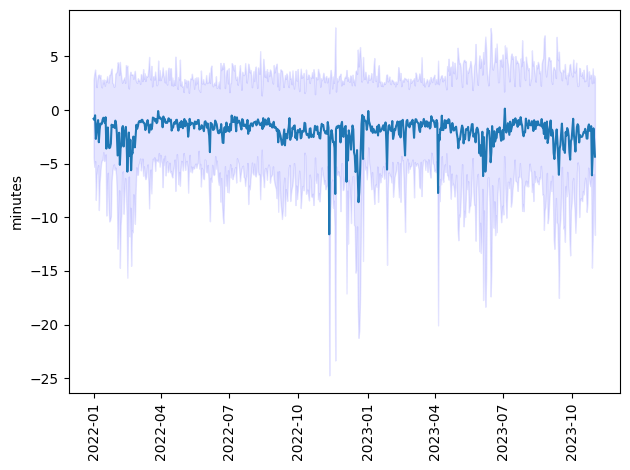

In [5]:
# visualize if data avail else use pre-computed ones
try:
    display(plot_timeseries(df))
except:
    display(Markdown("<img src='../images/timeline_deviation.png' width='100%'>"))

Takeaways from the time series above are:

* **Imbalance Data**: By our status standards, `89%` of the time buses are late, `11%` of the time they are on-schedule & rarely early.
  
* **Delays**: Busses are typically running `2 min` behind schedule, but that can excessively fluctuate `+/-5 min` in either early or delayed direction.

* **Stationary Process**: Average & standard deviations remain bounded providing travelers a reliable level of service. This also ensures statistical assumptions in our design hold.

* **Catastrophic Failures**: The dataset contains occasional outliers. These appear random events in both early & delayed directions. However, when things get delayed, they get excessively delayed & likely to re-occur in the following days.


----
## Spatiotemporal Analysis
This section looks at the specific location of bus stops & time periods that chronically deviate from scheduled times. The maps show the specific stops that deviate over `3min` ``delays`` with orange ➙ red colors (& conversely, ``early`` with green ➙ blue colors) . Purple zones on the map also denote frequent areas that deviate from schedule albeit not by the extreme amounts.

### Hourly

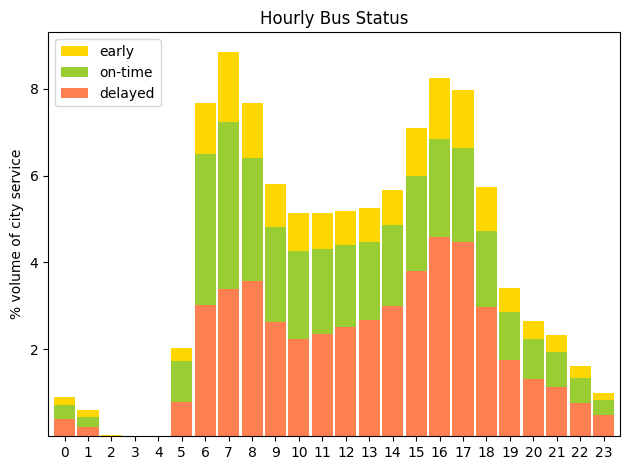

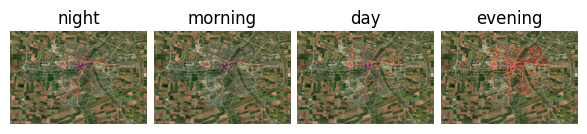

In [6]:
plot_histogram(df, freq_lbl='hourly')
plot_heatmap_img(lbl="daily", items=["night", "morning", "day", "evening"])

* **Rush Hours**: From the histogram & as expected there are service spikes between `6am-8am` & `4am-5pm`.
* **Accumulated Delays**: Deviations seem to accumulate throughout the day (ie: see relative proportions of histogram mid day & decay rates into the evening).
* **Bottlenecks**: Several routes on the north-east part of town are severely slow in the evenings (``4pm-8pm``). These are both due accumulated delays & bridge crossing bottlenecks
* **Premature Arrival**: Routes through ``grant ave`` on the west seem to be systematically ahead of schedule in the mornings.

### Daily

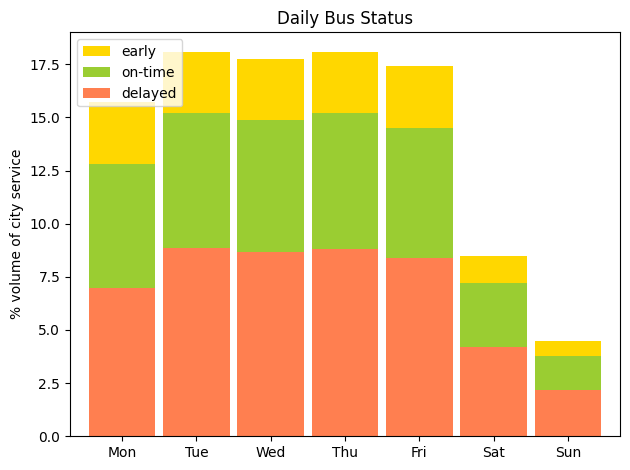

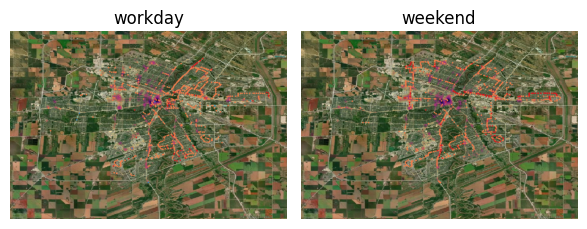

In [7]:
plot_histogram(df, freq_lbl='daily')
plot_heatmap_img(lbl="weekly", items=["workday", "weekend"])

* **Weekday Commuters**: Consistent ridership volume during the week. Halved on Saturday & halved on sunday.
* **Delayed Sundays**: Sundays experience a proportionally higher fraction of delays than rest of week.
* **Clogged Weekend Arteries**: Based on road topology & perhaps based on POI & zoning, we see routes through ``regent ave w`` & south ``pembina hwy`` to be particularly slow on weekends. Other key arteries have similar problem.
* **Weekday East Side**: East from the Red-River during the week exhibits moderate-high delays. Again due to geographic bottlenecks.

### Monthly

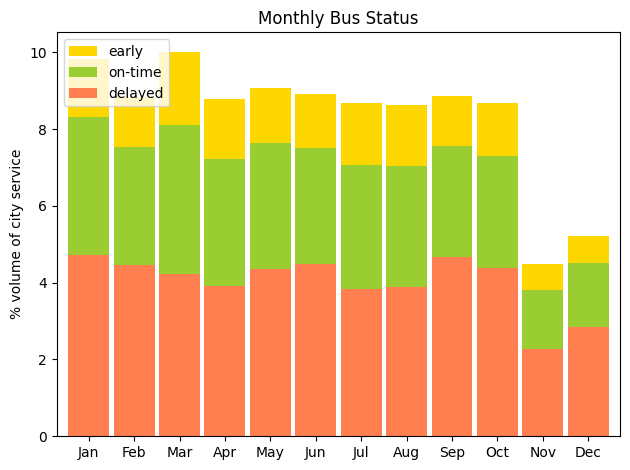

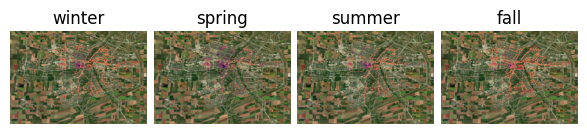

In [8]:
plot_histogram(df, freq_lbl='monthly')
plot_heatmap_img(lbl="seasonal", items=["winter", "spring", "summer", "fall"])

* **No Seasonal Pattern**: There is no clear difference in bus service across the seasons. More advanced spatial auto-correlation would need to be carried out to evaluate properly. 
* **Decreasing Ridership**: Throughout the year there seems to be a slight decrease in volume of ridership. Perhaps due to the convinence of driving in bad/cold weather.

> ⚠️ **WARN**: Given we took only 2 year history, the dips in november & december are attributed to the data not being published by the city portal at time of this analysis.

----
## **[<<PREV](part1_insights.ipynb)** | **[NEXT>>](part2_design.ipynb)**